#### Pkg instalación

In [1]:
using Pkg
#Pkg.add("Downloads")
#Pkg.add("ScikitLearn")
#Pkg.add("EvalMetrics")
#Pkg.add("MLJ")

In [2]:
using CSV
using DataFrames
using DataStructures
using DecisionTree
using Distances
using Downloads
using GLMNet
using LIBSVM
using LinearAlgebra
using MLJ
using NearestNeighbors
using Plots
using Printf: @sprintf
using RDatasets
using Random
using Statistics
using StatsPlots
#using EvalMetrics

# 0.Obtención del CSV y análisis de los datos

In [3]:
# Descargar el archivo CSV
url = "https://raw.githubusercontent.com/intro-stat-learning/ISLP/main/ISLP/data/Smarket.csv"
file = "../dat/Smarket.csv"
Downloads.download(url, file)

# Leer el archivo CSV
df = CSV.read(file, DataFrame)

# Mostrar los nombres de la cabecera
@show names(df)
@show size(df)

names(df) = ["Year", "Lag1", "Lag2", "Lag3", "Lag4", "Lag5", "Volume", "Today", "Direction"]
size(df) = (1250, 9)


(1250, 9)

In [4]:
# Esta función devuelve algunas caracteristicas interesantes, como el mínimo, el máximo, la cantidad de valores no presentes por columna entre otros.
describe(df)

9×7 DataFrame
 Row │ variable   mean       min      median   max      nmissing  eltype   
     │ Symbol     Union…     Any      Union…   Any      Int64     DataType 
─────┼─────────────────────────────────────────────────────────────────────
   1 │ Year       2003.02    2001     2003.0   2005            0  Int64
   2 │ Lag1       0.0038344  -4.922   0.039    5.733           0  Float64
   3 │ Lag2       0.0039192  -4.922   0.039    5.733           0  Float64
   4 │ Lag3       0.001716   -4.922   0.0385   5.733           0  Float64
   5 │ Lag4       0.001636   -4.922   0.0385   5.733           0  Float64
   6 │ Lag5       0.0056096  -4.922   0.0385   5.733           0  Float64
   7 │ Volume     1.4783     0.35607  1.42295  3.15247         0  Float64
   8 │ Today      0.0031384  -4.922   0.0385   5.733           0  Float64
   9 │ Direction             Down              Up              0  String7

En este conjunto de datos Lag1 a Lag5 representan los rendimientos porcentuales del índice S&P 500 durante los 5 días de negociación previos a la fecha de interés.
Los años varian desde el 2001 hasta el 2005. No hay perdidas en los datos.
La variable Direction indica la subida o la baja en las acciones, esta podría ser la variable de interés.

In [5]:
first(df, 5)

5×9 DataFrame
 Row │ Year   Lag1     Lag2     Lag3     Lag4     Lag5     Volume   Today    D ⋯
     │ Int64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  S ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2001    0.381   -0.192   -2.624   -1.055    5.01    1.1913    0.959  U ⋯
   2 │  2001    0.959    0.381   -0.192   -2.624   -1.055   1.2965    1.032  U
   3 │  2001    1.032    0.959    0.381   -0.192   -2.624   1.4112   -0.623  D
   4 │  2001   -0.623    1.032    0.959    0.381   -0.192   1.276     0.614  U
   5 │  2001    0.614   -0.623    1.032    0.959    0.381   1.2057    0.213  U ⋯
                                                                1 column omitted

Para una mejor manipulación de los datos, la variable Directions se convierte a una variable númerica binaria

In [6]:
directionlabels = df[:,9]
 # Change up = 1 and down = 0.
df.Direction = ifelse.(df.Direction .== "Down", 0, 1);

## 0.1 Matriz de correlación

Se redefine el dataFrame a una Matriz de (1250, 9) dimensiones. Posteriormente se calcula la matriz correlación con el fin de visualizar la correlación entre las diferentes variables.

In [7]:
M = Matrix(df);
corM = cor(M) #, dims=1)

9×9 Matrix{Float64}:
 1.0         0.0296996    0.0305964   …   0.0300952    0.0746083
 0.0296996   1.0         -0.0262943      -0.026155    -0.0397573
 0.0305964  -0.0262943    1.0            -0.01025     -0.0240815
 0.0331946  -0.0108034   -0.0258967      -0.00244765   0.00613151
 0.0356887  -0.00298591  -0.0108535      -0.00689953   0.00421521
 0.029788   -0.00567461  -0.00355795  …  -0.0348601    0.00542257
 0.539006    0.0409099   -0.0433832       0.0145918    0.022951
 0.0300952  -0.026155    -0.01025         1.0          0.730563
 0.0746083  -0.0397573   -0.0240815       0.730563     1.0

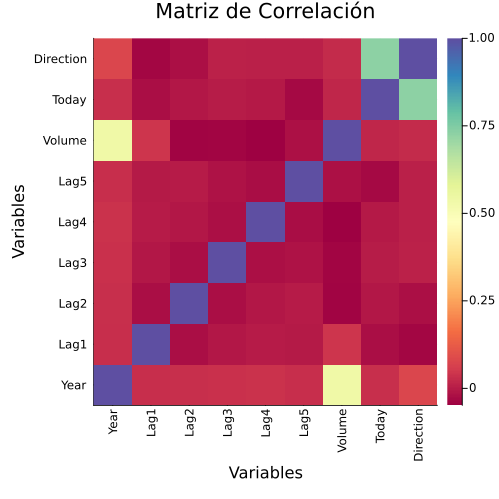

In [8]:
column_names = names(df)
heatmap(   corM,
		    xlabel = "Variables",
		    ylabel = "Variables",
		    xticks = (1:length(column_names), column_names),
		    yticks = (1:length(column_names), column_names),
		    color=:Spectral,
		    title = "Matriz de Correlación",
				xrotation = 90,
		    size=(500, 500))


## 0.2 Definición de la variable dependiente a predecir *y*, y del conjunto de variables caracteristicas *X*.

In [9]:
y = M[:,:9]
X = M[:,1:8];

## 0.3 Definición de funciones

La función *perclass_splits* dividirá las instancias de datos por clase (0 o 1). Realiza una selección aleatoria de un subconjunto de instancias de cada clase de acuerdo con el parámetro at. 
Tipicamente los datos de entrenamiento y de prueba se dividen en una proporción 70/30 del total de datos.

In [10]:
#= La función perclass_splits divide las instancias de datos por clase 
(etiqueta), seleccionando aleatoriamente un subconjunto de instancias de cada
clase de acuerdo con el parámetro at, posteriormente se define como '.7
ya que tipicamente el entrenamiento es de 70% y testing es de 30% de los datos=#
function perclass_splits(y,at)
    uids = unique(y)
    keepids = []
    for ui in uids
        curids = findall(y.==ui)
        rowids = randsubseq(curids, at) 
        push!(keepids,rowids...)
    end
    return keepids
end

perclass_splits (generic function with 1 method)

Función para asignar una clase (0 para 'down' y 1 para 'up') basándose en el valor predicho.
El valor predicho se supone que es una probabilidad entre 0 y 1

In [11]:
function assign_class(predictedvalue)
    # Calcula la diferencia absoluta entre el valor predicho y los valores posibles de clase (0 o 1).
    # Esto nos ayuda a determinar a cuál clase (down o up) está más cerca el valor predicho.
    differences = abs.(predictedvalue .- [0, 1])  # Calcula la diferencia con 'down' (0) y 'up' (1)
    
    # Encuentra el índice del valor con la menor diferencia, es decir, la clase más cercana al valor predicho
    closest_class_index = argmin(differences)
    
    # Devuelve 0 si el valor predicho está más cercano a 'down' (0), o 1 si está más cercano a 'up' (1)
    return closest_class_index - 1  # Se resta 1 para que 1 corresponda a 'up' y 0 a 'down'
end


assign_class (generic function with 1 method)

Esta funcion se utiliza para comparar todos los clasificadores usados

In [12]:
findaccuracy(predictedvals,groundtruthvals) = sum(predictedvals.==groundtruthvals)/length(groundtruthvals)

findaccuracy (generic function with 1 method)

A continuación se realiza la separación de los datos de entrenamiento y el resto se resto se asigna a los datos de prueba. 
*trainids* guarda los índices de las filas seleccionadas para el entrenamiento, y *testids* contiene las filas que se usan para la prueba.

In [13]:
trainids = perclass_splits(y,0.7);
testids = setdiff(1:length(y),trainids);
@show size(trainids)
@show size(testids)

size(trainids) = (871,)
size(testids) = (379,)


(379,)

## 0.3 Definiciones de Matriz de confusión y Curva ROC

In [14]:
function build_confusion_matrix(predictions, truth)
    # Inicializar los valores de la matriz de confusión
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    # Iterar a través de las predicciones y las verdaderas etiquetas
    for (p, gt) in zip(predictions, truth)
        if p == 1 && gt == 1  # Predicción positiva correcta
            TP += 1
        elseif p == 1 && gt == 0  # Predicción positiva incorrecta
            FP += 1
        elseif p == 0 && gt == 0  # Predicción negativa correcta
            TN += 1
        elseif p == 0 && gt == 1  # Predicción negativa incorrecta
            FN += 1
        end
    end
    
    # Devolver la matriz de confusión como un diccionario o como una matriz
    confusion_matrix = [TP FP; FN TN]
    println("Matriz de Confusión:")
    println("TP = $(confusion_matrix[1, 1]), FP = $(confusion_matrix[1, 2])")
    println("FN = $(confusion_matrix[2, 1]), TN = $(confusion_matrix[2, 2])")
    
    return confusion_matrix
end;

In [15]:
# Función para calcular la Curva ROC y AUC
function calculate_roc(ground_truth, predictions_prob, n)
    thresholds = LinRange(0, 1, n)  # Umbrales posibles de predicción
    TPR = Float64[]  # Tasa de verdaderos positivos (Recall)
    FPR = Float64[]  # Tasa de falsos positivos
    auc = 0.0  # Área bajo la curva (AUC)

    # Calcular TPR y FPR para cada umbral
    for threshold in thresholds
        # Predicción binaria con el umbral
        predictions = predictions_prob .>= threshold

        # Calcular los valores de TP, FP, FN y TN
        TP = sum((predictions .== 1) .& (ground_truth .== 1))
        FP = sum((predictions .== 1) .& (ground_truth .== 0))
        FN = sum((predictions .== 0) .& (ground_truth .== 1))
        TN = sum((predictions .== 0) .& (ground_truth .== 0))

        # Calcular TPR (Recall) y FPR
        push!(TPR, TP / (TP + FN))
        push!(FPR, FP / (FP + TN))
    end
    # Ordenar FPR y TPR en orden ascendente de FPR para el cálculo correcto del AUC
    sorted_indices = sortperm(FPR)
    FPR = FPR[sorted_indices]
    TPR = TPR[sorted_indices]

    # Calcular AUC usando la regla de los trapecios (trapezoidal rule)
    auc = sum(diff(FPR) .* (TPR[1:end-1] .+ TPR[2:end]) / 2)

    # Graficar la curva ROC
    p = plot(FPR, TPR, label="Curva ROC", xlabel="FPR (Tasa de Falsos Positivos)", 
    ylabel="TPR (Tasa de Verdaderos Positivos)", title="Curva ROC", linewidth=2, color=:blue)
    plot!(xlims=(0, 1), ylims=(0, 1))  # Límites de los ejes de la gráfica
    plot!(legend=:topright)  # Leyenda en la esquina superior derecha
    # Forzar la visualización del gráfico
    display(p)

    return FPR, TPR, auc
end;

## 0.4 Definición de parámetros para la regresión

*glmnet* ajusta un modelo de regresión regularizada con diferentes valores de lambda.

*glmnetcv* realiza una validación cruzada para determinar el mejor valor de lambda.

In [16]:
path = glmnet(X[trainids,:], y[trainids])
cv = glmnetcv(X[trainids,:], y[trainids])

Least Squares GLMNet Cross Validation
66 models for 8 predictors in 10 folds
Best λ 0.012 (mean loss 0.119, std 0.004)

Una vez que glmnetcv ha determinado el valor óptimo de λ, se ajustará el modelo final con este parámetro y se realizará la predicción sobre el conjunto de prueba.

In [17]:
mylambda = path.lambda[argmin(cv.meanloss)]
path = glmnet(X[trainids,:], y[trainids],lambda=[mylambda]);

Aquí, *q* es el conjunto de prueba (matriz de características), testids es un conjunto de índices aleatorios con el cual se indexaran algunas filas de la matriz *X* formando el conjunto de X de prueba *X testing*.
*X testing* contendrá las características de prueba que se usarán para hacer las predicciones con el modelo previamente entrenado.

*GLMNet.predict(path,q)* realizará una predicción usando el modelo de regresión regularizada entrenado. 

*path* es la ruta de modelo ya entrenado X train. Entonces el resultado de *GLMNet.predict(path,q)* será un vector o una matriz con las predicciones para cada una de las observaciones en *q*.
*predictions_lasso* contiene las predicciones del modelo Lasso para cada instancia de prueba.

# 1. Ejecución de los modelos

Las predicciones de GLMNet.predict generalmente devuelven valores entre 0 y 1 (probabilidades), por ello las clases correspondientes se asignan con la función assign_class:

#### Lasso, Ridge y Elastic Net: 
    A grandes rasgos son técnicas de regularización utilizadas en regresión para mejorar la generalización de los modelos y prevenir el sobreajuste (overfitting).
    
#### Penalizaciones:

    alpha = 1: Lasso (solo L1).
    alpha = 0: Ridge (solo L2).
    0 < alpha < 1: Mezcla de Lasso y Ridge.

## 1.1 Lasso (Least Absolute Shrinkage Selection Operator)

In [42]:
q = X[testids,:];
predictions_lasso = GLMNet.predict(path,q)
@show(predictions_lasso) # ---> Aquí se muestran en terminos de probabilidades
#Calcular precisión: Se calcula la precisión del modelo, comparando las clases predichas con las etiquetas reales en el conjunto de prueba usando findaccuracy.
predictions_lasso_as = assign_class.(predictions_lasso)
findaccuracy(predictions_lasso_as,y[testids])

predictions_lasso = [0.9226927739522173; 0.7334408231203905; 0.3248484534356742; 0.4623578528449579; 0.057433304567670006; 0.8723708135403041; 0.7523080155547254; -0.11599035639941825; 0.32650524909344986; 0.8045731442669792; -0.28305105293274474; -0.3171667315291354; 0.8679401921263333; 1.2734812472535755; 0.8733825680286272; 0.11006693953695292; -0.5547926711701816; 1.0306438781324319; 0.38484195370441526; 0.8900289099080387; 0.1339810373875962; 0.4188722321558151; 1.3862724683793974; 1.0228333851964886; 0.04559427138839994; 0.26674489045312905; 0.639146849761664; 0.680686145217618; 0.33060495158987796; 0.6011122280618384; 0.4605452961552473; 1.2330975721829212; 0.1643898623132493; 0.805739149586916; 0.8285106895663498; 0.5636728899808691; 0.6359551122734477; 0.33940921014378395; 0.6104865929477032; 0.49655033903227674; 0.5079418931009674; 0.382456535414573; 0.24956640847183545; 0.7528327051746483; 0.7023691145374924; 1.0926290685995714; 0.3598000406601511; 0.6433393651324294; -0.217

0.9525065963060686

In [19]:
y_pred = vec(predictions_lasso_as);  # Estas son las predicciones binarias (0 o 1)
y_true = Int64.(y[testids]);     # Las etiquetas reales del conjunto de prueba (0 o 1)
@show y_pred
@show y_true;

y_pred = [1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 

Algunas metricas:

$$ Accuracy = \frac{TP+TN}{FP+FN + TP+TN​} $$
$$ Recall = \frac{TP}{FN + TP​} $$
$$ F1=2 \frac{Precision + Recall}{Precision Recall​} $$
$$Precision = \frac{TP}{FP + TP}$$

### 1.1.2 Calculo de la curva ROC, el área AUC y la matriz de confusión

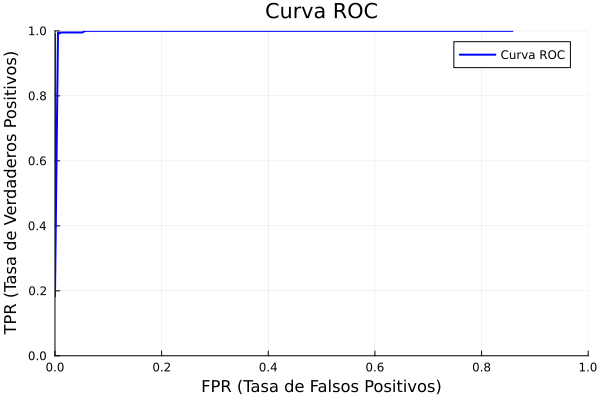

Matriz de Confusión:
TP = 203, FP = 19
FN = 0, TN = 157
Área bajo la curva (AUC): 0.8553655396327811


In [20]:
conf_matrix = build_confusion_matrix(y_pred, y_true)
# Calcular la Curva ROC y AUC
FPR, TPR, auc = calculate_roc(y_true, predictions_lasso, 3000)
println("Área bajo la curva (AUC): ", auc)

In [21]:
  TP = conf_matrix[1, 1]
  FP = conf_matrix[1, 2]
  FN = conf_matrix[2, 1]
  TN = conf_matrix[2, 2]
  
  # Exactitud (AC)
   AC = (TP + TN) / (TP + TN + FP + FN)
    
   # Precisión (PC)
   PC = TP / (TP + FP)
   
   # Recall (RE)
   RE = TP / (FN + TP) # ---> Verdaderos positivos
   
   # F1-Score
   F1 = 2 * (PC * RE) / (PC + RE)

println("Accuracy: $AC")
println("Precision: $PC")
println("Recall: $RE")
println("F1 Score: $F1")

Accuracy: 0.9498680738786279
Precision: 0.9144144144144144
Recall: 1.0
F1 Score: 0.9552941176470588


## 1.2. Ridge

In [22]:
# choose the best lambda to predict with.
path = glmnet(X[trainids,:], y[trainids],alpha=0);
cv = glmnetcv(X[trainids,:], y[trainids],alpha=0)
mylambda = path.lambda[argmin(cv.meanloss)]
path = glmnet(X[trainids,:], y[trainids],alpha=0,lambda=[mylambda]);
q = X[testids,:];
predictions_ridge = GLMNet.predict(path,q)
predictions_ridge_as = assign_class.(predictions_ridge);



In [23]:
findaccuracy(predictions_ridge_as,y[testids])

0.9472295514511874

### 1.2.1 Calculo de la curva ROC, el área AUC y la matriz de confusión

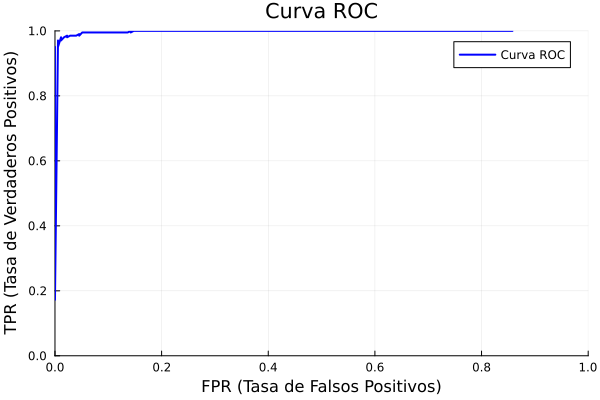

Matriz de Confusión:
TP = 202, FP = 19
FN = 1, TN = 157
Área bajo la curva (AUC): 0.8542459695476936


In [24]:
conf_matrix = build_confusion_matrix(predictions_ridge_as, y_true)
FPR, TPR, auc = calculate_roc(y_true, predictions_ridge, 10000)
println("Área bajo la curva (AUC): ", auc)

## 1.3. Elastic Net

In [25]:
# choose the best lambda to predict with.
path = glmnet(X[trainids,:], y[trainids],alpha=0.5);
cv = glmnetcv(X[trainids,:], y[trainids],alpha=0.5)
mylambda = path.lambda[argmin(cv.meanloss)]
path = glmnet(X[trainids,:], y[trainids],alpha=0.5,lambda=[mylambda]);
q = X[testids,:];
predictions_EN = GLMNet.predict(path,q)
predictions_EN_as = assign_class.(predictions_EN)
findaccuracy(predictions_EN_as,y[testids])

0.9525065963060686

### 1.3.1 Calculo de la curva ROC, el área AUC y la matriz de confusión

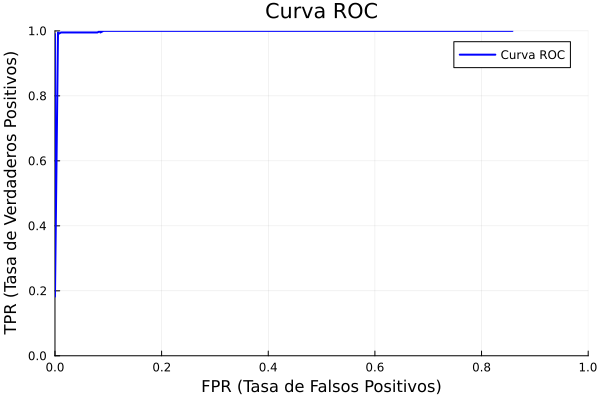

Matriz de Confusión:
TP = 203, FP = 18
FN = 0, TN = 158
Área bajo la curva (AUC): 0.8552115987460815


In [26]:
conf_matrix = build_confusion_matrix(predictions_EN_as, y_true)
FPR, TPR, auc = calculate_roc(y_true, predictions_EN, 1000)
println("Área bajo la curva (AUC): ", auc)

## 1.4.Decision Tree

In [27]:
model = DecisionTreeClassifier(max_depth=2)
DecisionTree.fit!(model, X[trainids,:], y[trainids])

DecisionTreeClassifier
max_depth:                2
min_samples_leaf:         1
min_samples_split:        2
min_purity_increase:      0.0
pruning_purity_threshold: 1.0
n_subfeatures:            0
classes:                  [0.0, 1.0]
root:                     Decision Tree
Leaves: 2
Depth:  1

In [28]:
q = X[testids,:];
predictions_DT = DecisionTree.predict(model, q)
findaccuracy(predictions_DT,y[testids])

1.0

### 1.4.1 Calculo de la curva ROC, el área AUC y la matriz de confusión

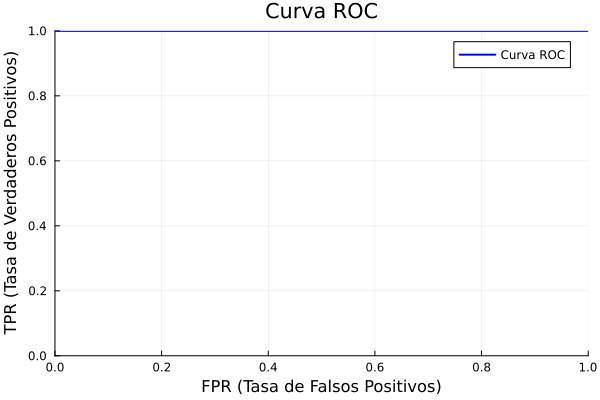

Matriz de Confusión:
TP = 203, FP = 0
FN = 0, TN = 176
Área bajo la curva (AUC): 1.0


In [29]:
conf_matrix = build_confusion_matrix(predictions_DT, y_true)
FPR, TPR, auc = calculate_roc(y_true, predictions_DT, 1000)
println("Área bajo la curva (AUC): ", auc)

## 1.5. Random Forest

In [30]:
model = RandomForestClassifier(n_trees=20)
DecisionTree.fit!(model, X[trainids,:], y[trainids])

RandomForestClassifier
n_trees:             20
n_subfeatures:       -1
partial_sampling:    0.7
max_depth:           -1
min_samples_leaf:    1
min_samples_split:   2
min_purity_increase: 0.0
classes:             [0.0, 1.0]
ensemble:            Ensemble of Decision Trees
Trees:      20
Avg Leaves: 11.65
Avg Depth:  4.6

In [31]:
q = X[testids,:];
predictions_RF = DecisionTree.predict(model, q)
findaccuracy(predictions_RF,y[testids])

0.5857519788918206

### 1.5.1 Calculo de la curva ROC, el área AUC y la matriz de confusión

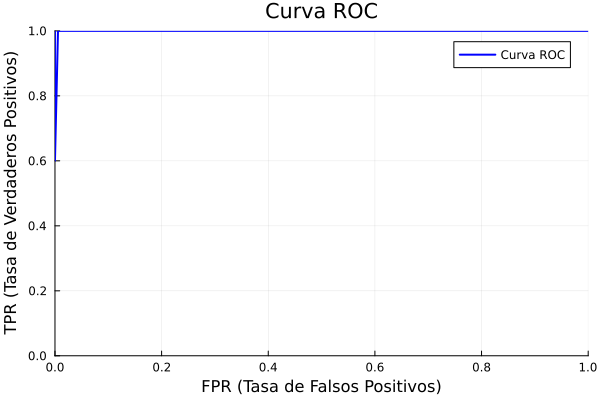

Matriz de Confusión:
TP = 122, FP = 0
FN = 0, TN = 100
Área bajo la curva (AUC): 0.998866435288849


In [32]:
conf_matrix = build_confusion_matrix(predictions_RF, y_true)
FPR, TPR, auc = calculate_roc(y_true, predictions_RF, 1000)
println("Área bajo la curva (AUC): ", auc)

## 1.6. Nearest Neighbors

In [33]:
Xtrain = X[trainids,:]
ytrain = y[trainids]
kdtree = KDTree(Xtrain')

KDTree{StaticArraysCore.SVector{8, Float64}, Euclidean, Float64, StaticArraysCore.SVector{8, Float64}}
  Number of points: 871
  Dimensions: 8
  Metric: Euclidean(0.0)
  Reordered: true

In [34]:
queries = X[testids,:]

379×8 Matrix{Float64}:
 2001.0   0.027  -0.403   1.392   0.213   0.614  1.164     1.303
 2001.0   0.68   -0.189  -0.498   0.287   1.303  1.0531    0.701
 2001.0   0.701   0.68   -0.189  -0.498   0.287  1.1498   -0.562
 2001.0   0.359  -1.747   0.546  -0.562   0.701  1.013    -0.151
 2001.0  -0.623  -0.841  -0.151   0.359  -1.747  1.1072   -1.334
 2001.0  -1.334  -0.623  -0.841  -0.151   0.359  1.0755    1.183
 2001.0  -0.218  -0.865   1.183  -1.334  -0.623  1.1503    0.812
 2001.0   0.812  -0.218  -0.865   1.183  -1.334  1.1537   -1.891
 2001.0  -0.195  -1.851  -1.736  -1.891   0.812  1.3659   -0.556
 2001.0   0.586  -0.568   0.104  -1.431  -0.766  0.9292    0.998
    ⋮                                     ⋮               
 2005.0  -0.636   0.002  -0.851   0.209   0.347  2.37469   1.216
 2005.0   0.032   1.216  -0.636   0.002  -0.851  2.12558  -0.236
 2005.0   0.128  -0.236   0.032   1.216  -0.636  2.11074  -0.501
 2005.0  -0.501   0.128  -0.236   0.032   1.216  2.09383  -0.122
 2005.0 

In [35]:
idxs, dists = knn(kdtree, queries', 5, true)

([[72, 62, 4, 83, 68], [49, 82, 5, 84, 83], [537, 488, 15, 448, 447], [562, 506, 162, 498, 32], [485, 499, 565, 638, 477], [31, 157, 42, 51, 161], [74, 50, 72, 476, 38], [485, 499, 543, 482, 624], [510, 626, 37, 588, 113], [40, 38, 50, 32, 83]  …  [380, 369, 399, 869, 830], [421, 417, 414, 426, 370], [849, 819, 815, 852, 853], [863, 850, 828, 838, 420], [829, 825, 369, 387, 406], [427, 436, 445, 868, 435], [869, 854, 867, 863, 399], [842, 443, 369, 399, 829], [412, 380, 407, 369, 399], [847, 802, 867, 393, 828]], [[1.0278161751986588, 1.4421999999999997, 1.524208939089389, 1.6879355467552661, 1.7650012039655951], [1.1565825564999672, 1.3575471869883566, 1.4549848796465206, 1.5944480675142731, 1.681298902634508], [1.050572586735443, 1.1658751564382868, 1.1681300270089798, 1.3658959111147526, 1.4224812968893477], [1.3129472342786666, 1.368399006138195, 1.4436405508297416, 1.4546014058841, 1.4743768310713512], [1.3126155149166872, 1.80801457129084, 1.82172903857846, 1.83160672907696, 1.84

In [36]:
c = ytrain[hcat(idxs...)]
possible_labels = map(i->counter(c[:,i]),1:size(c,2))
#predictions_NN = map(i->parse(Int,string(string(argmax(possible_labels[i])))),1:size(c,2))
predictions_NN = map(i -> argmax(possible_labels[i])[1], 1:size(c, 2))
findaccuracy(predictions_NN,y[testids])

0.862796833773087

### 1.6.1 Calculo de la curva ROC, el área AUC y la matriz de confusión

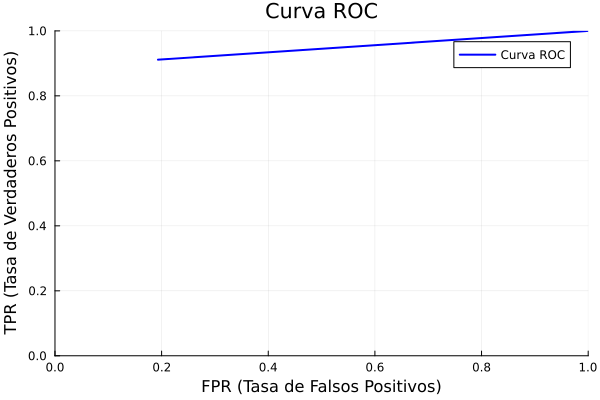

Matriz de Confusión:
TP = 185, FP = 34
FN = 18, TN = 142
Área bajo la curva (AUC): 0.7710479175996418


In [37]:
conf_matrix = build_confusion_matrix(predictions_NN, y_true)
FPR, TPR, auc = calculate_roc(y_true, predictions_NN, 1000)
println("Área bajo la curva (AUC): ", auc)

## 1.7.Support Vector Machines (SVM)

In [38]:
Xtrain = X[trainids,:]
ytrain = y[trainids];
model = svmtrain(Xtrain', ytrain)
predictions_SVM, decision_values = svmpredict(model, X[testids,:]')
findaccuracy(predictions_SVM,y[testids])

0.9393139841688655

### 1.7.1 Calculo de la curva ROC, el área AUC y la matriz de confusión

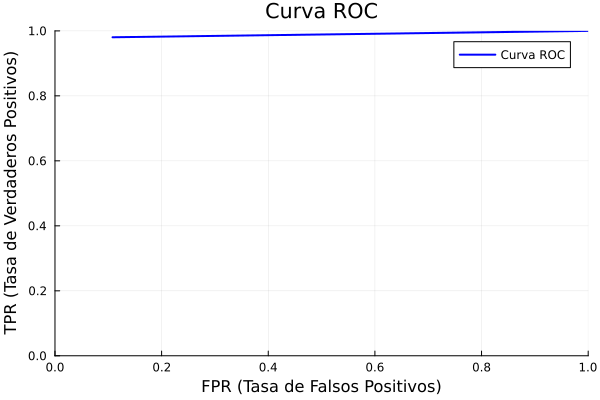

Matriz de Confusión:
TP = 199, FP = 19
FN = 4, TN = 157
Área bajo la curva (AUC): 0.883256829377519


In [39]:
conf_matrix = build_confusion_matrix(predictions_SVM, y_true)
FPR, TPR, auc = calculate_roc(y_true, predictions_SVM, 1000)
println("Área bajo la curva (AUC): ", auc)

# 2. Resumen

In [40]:
overall_accuracies = zeros(7)
methods = ["lasso","ridge","EN", "DT", "RF","kNN", "SVM"]
ytest = y[testids]
overall_accuracies[1] = findaccuracy(predictions_lasso_as,ytest)
overall_accuracies[2] = findaccuracy(predictions_ridge_as,ytest)
overall_accuracies[3] = findaccuracy(predictions_EN_as,ytest)
overall_accuracies[4] = findaccuracy(predictions_DT,ytest)
overall_accuracies[5] = findaccuracy(predictions_RF,ytest)
overall_accuracies[6] = findaccuracy(predictions_NN,ytest)
overall_accuracies[7] = findaccuracy(predictions_SVM,ytest)
hcat(methods, overall_accuracies)

7×2 Matrix{Any}:
 "lasso"  0.949868
 "ridge"  0.94723
 "EN"     0.952507
 "DT"     1.0
 "RF"     0.585752
 "kNN"    0.862797
 "SVM"    0.939314

In [41]:
println("\n==== Model Accuracy Comparison ====")
println("Method                           | Accuracy (%)")
println("-----------------------------------|------------")
for i in 1:length(methods)
    # Imprimir con alineación para una presentación más clara
    println(@sprintf("%-35s| %-10.2f", methods[i], overall_accuracies[i] * 100))
end
println("===================================")


==== Model Accuracy Comparison ====
Method                           | Accuracy (%)
-----------------------------------|------------
lasso                              | 94.99     
ridge                              | 94.72     
EN                                 | 95.25     
DT                                 | 100.00    
RF                                 | 58.58     
kNN                                | 86.28     
SVM                                | 93.93     
